# Delivery Duration Prediction

## Table of Contents

- [Objective](#objective)
- [Setup](#setup)
- [Explore Data](#explore-data)
- [Remove Redundant and Collinear Features](#remove-features)
    - [Multicollinearity Check](#multicollinearity-check)
    - [Feature Selection](#feature-selection)
- [Apply Scaler](#apply-scaler)
    - [Inverse Transform for Metric Comparison](#inverse-transform)
- [Machine Learning Models](#ml-models)
- [Deep Learning Model](#dl-model)

## Objective <a id='objective'></a>

Build a model to predict the estimated time taken for a delivery.

For a given delivery, the model should predict the total delivery duration in seconds, which is the time taken from:

- Start: the time consumer submits the order (`created_at`) to
- End: when the order will be delivered to the consumer (`actual_delivery_time`)

When a consumer places an order on DoorDash, the expected time of delivery is shown. The accuracy of this information is important to DoorDash because it has a substantial impact on consumer experience.

## Setup <a id='setup'></a>

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine learning
from sklearn import linear_model, tree, svm, neighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
# Set random seed for reproducible results
np.random.seed(seed=42)

## Explore Data <a id='explore-data'></a>

In [3]:
# Read data
historical_data = pd.read_csv('data/raw/historical_data.csv')
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
# Information on DataFrame
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
# Create target variable for regression
historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()

# Show first 5 rows
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0


In [6]:
# Create new features
historical_data['estimated_non_prep_duration'] = historical_data['estimated_store_to_consumer_driving_duration'] + historical_data['estimated_order_place_duration']
historical_data['busy_dashers_ratio'] = historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers']

# Show first 5 rows
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [7]:
# Check ids for encoding
print(f'Number of unique market id: {historical_data.market_id.nunique()}')
print(f'Number of unique store id: {historical_data.store_id.nunique()}')
print(f'Number of unique order protocol: {historical_data.order_protocol.nunique()}')

Number of unique market id: 6
Number of unique store id: 6743
Number of unique order protocol: 7


In [8]:
# Calculate mode for each store id
store_modes = historical_data.groupby(by='store_id')['store_primary_category'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Fill null values with mode for each store id
historical_data['nan_free_store_primary_category'] = historical_data['store_primary_category'].fillna(value=store_modes)

# Show first 5 rows
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000,mexican
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000,indian


In [9]:
# Create dummies for order protocol
order_protocol_dummies = pd.get_dummies(data=historical_data['order_protocol'], prefix='order_protocol', dtype='int64')

# Show first 5 rows
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [10]:
# Create dummies for market id
market_id_dummies = pd.get_dummies(data=historical_data['market_id'], prefix='market_Id', dtype='int64')

# Show first 5 rows
market_id_dummies.head()

,market_Id_1.0,market_Id_2.0,market_Id_3.0,market_Id_4.0,market_Id_5.0,market_Id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [11]:
# Create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(data=historical_data['nan_free_store_primary_category'], prefix='category', dtype='int64')

# Show first 5 rows
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Drop categorical and datetime columns
train_df = historical_data.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'nan_free_store_primary_category'])

# Show first 5 rows
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,estimated_non_prep_duration,busy_dashers_ratio
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,1307.0,0.424242
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1136.0,2.000000
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,1136.0,0.000000
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,735.0,1.000000
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1096.0,1.000000


In [13]:
# Concatenate data frames
train_df = pd.concat(objs=[train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)

# Set dtype over data
train_df = train_df.astype('float32')

# Show first 5 rows
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Summary statistics for training data
train_df.describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000800,0.000187,0.005562,0.011219,0.000745,0.037345,0.001221,0.001418,0.004285,0.031110
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028278,0.013689,0.074368,0.105326,0.027277,0.189607,0.034917,0.037633,0.065320,0.173616
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Summary statistics for `busy_dashers_ratio` feature
train_df['busy_dashers_ratio'].describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [16]:
# Check infinity values
np.where(np.any(~np.isfinite(train_df), axis=0) == True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [17]:
# Replace infinity values with nan
train_df.replace(to_replace=[np.inf, -np.inf], value=np.nan, inplace=True)

# Drop rows with nan values
train_df.dropna(inplace=True)

In [18]:
# Check for nan values
train_df.isna().sum().sum()

0

In [19]:
# Shape of training data
train_df.shape

(177070, 100)

## Remove Redundant and Collinear Features <a id='remove-features'></a>

In the final dataset with 100 columns, potential issues include redundant features that do not offer new information due to repetition or zero standard deviation. Here, collinearity will be examined, starting with a correlation matrix.

<Axes: >

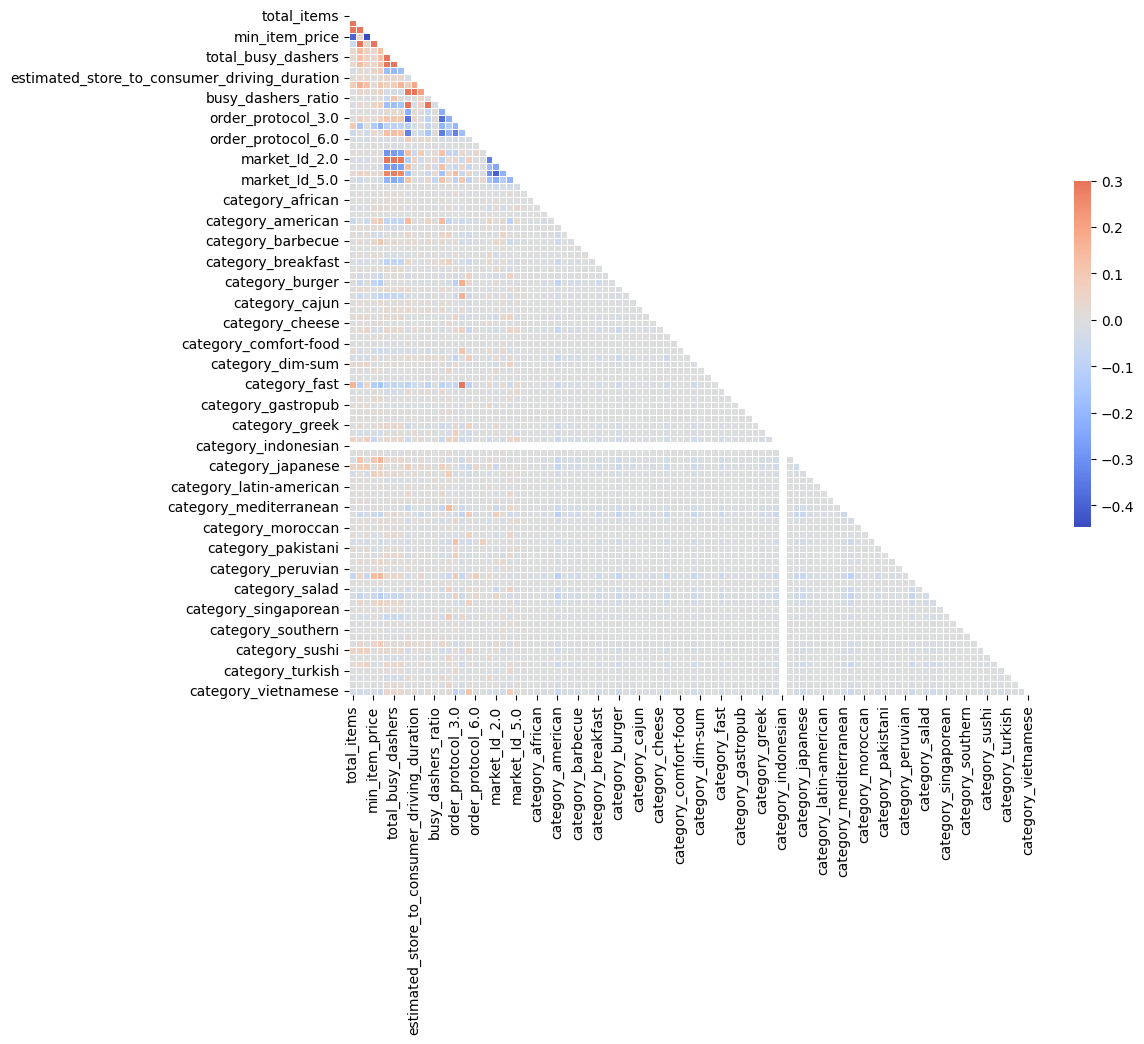

In [20]:
# Generate mask for upper triangle
mask = np.triu(m=train_df.corr())

# Set matplotlib figure
plt.figure(figsize=(11, 9))

# Plot heat map
sns.heatmap(data=train_df.corr(), mask=mask, cmap='coolwarm', vmax=0.3, center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})

In [21]:
# Check category_indonesian
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

This feature has zero standard deviation so it can be dropped from the training data.

In [22]:
# Define function to get top absolute correlations
def get_top_abs_correlations(df, n):
    """
    This function sorts correlations in descending order and returns n highest results.
    """
    au_corr = df.corr().abs().unstack()
    
    # Create mask for upper triangle to exclude redundant pairs
    labels_to_drop = set([(df.columns[i], df.columns[j]) for i in range(df.shape[1]) for j in range(i+1)])
    
    # Get top n correlations
    top_corr = au_corr.drop(labels=labels_to_drop).nlargest(n)
    
    return top_corr

In [23]:
# Get results for top absolute correlations between features
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489646
num_distinct_items          

In [24]:
# Drop categorical and datetime columns
train_df = historical_data.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'nan_free_store_primary_category'])

# Concatenate data frames excluding market id and order protocol
train_df = pd.concat(objs=[train_df, store_primary_category_dummies], axis=1)

# Drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'estimated_non_prep_duration', 'category_indonesian'])

# Set data type over data set
train_df = train_df.astype('float32')

# Replace infinity values with nan
train_df = train_df.replace(to_replace=[np.inf, -np.inf], value=np.nan)

# Drop all nan values
train_df = train_df.dropna()

# Show first 5 rows
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Shape of training data
train_df.shape

(177070, 83)

In [26]:
# Get highest 20 absolute correlations
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.16

There are still features with high correlations. The total number or distinct items may affect the duration of the preparation process so these features are kept.

New features can be created to infer the contribution of these columns.

In [27]:
# Create new features
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['average_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']

# Drop columns
train_df = train_df.drop(columns=['num_distinct_items', 'subtotal', 'max_item_price', 'min_item_price'])

In [28]:
# Get highest 20 absolute correlations
print('Top Absolute Correlations')
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              average_price_per_item            0.310759
percent_distinct_item_of_total                average_price_per_item            0.226711
category_pizza                                average_price_per_item            0.214116
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
total_outstanding_orders                      estimated_order_place_duration    0.171049
category_fast                                 average_price_per_item            0.167261
total_items                                   category_fast                     0.163940
total_outstanding_orders                      actual_total_delivery_duration    0.157604
category_italian                              average_price_per_item            0.15

In [29]:
# Shape of training data
train_df.shape

(177070, 82)

### Multicollinearity Check <a id='multicollinearity-check'></a>

In [30]:
# Define function to compute variance inflation factor (VIF)
def compute_vif(features):
    """
    Compute variance inflation factor (VIF)
    """
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(exog=train_df[features].values, exog_idx=i) for i in range(len(features))]
    return vif_data.sort_values(by='VIF').reset_index(drop=True)

In [31]:
# Get features
features = train_df.drop(columns='actual_total_delivery_duration')
features = features.loc[:, features.apply(pd.Series.nunique) != 1].columns.tolist()

# Compute VIF for all columns
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000371
1,category_chocolate,1.000503
2,category_belgian,1.000767
3,category_russian,1.003487
4,category_african,1.003604
...,...,...
76,busy_dashers_ratio,6.369090
77,category_american,6.951760
78,estimated_store_to_consumer_driving_duration,7.202637
79,estimated_order_place_duration,13.370854


In [32]:
# Drop features with VIF scores above 20 until all VIF scores are under 20
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print(f'Removing {highest_vif_feature} due to high VIF')
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data['VIF'] > 20]) == 0 else True

# Return vif_data
vif_data

Removing percent_distinct_item_of_total due to high VIF


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000373
2,category_belgian,1.000468
3,category_russian,1.002146
4,category_african,1.002863
...,...,...
75,category_american,4.438395
76,average_price_per_item,5.861428
77,busy_dashers_ratio,6.357336
78,estimated_store_to_consumer_driving_duration,7.184320


Only one feature, `percent_distinct_item_of_total` was dropped.

### Feature Selection <a id='feature-selection'></a>

In [33]:
# Select features
selected_features = vif_data['feature'].values.tolist()

# Split data
X = train_df[selected_features]
y = train_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Initialize and train model
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: xlabel='Feature', ylabel='Gini Importance'>

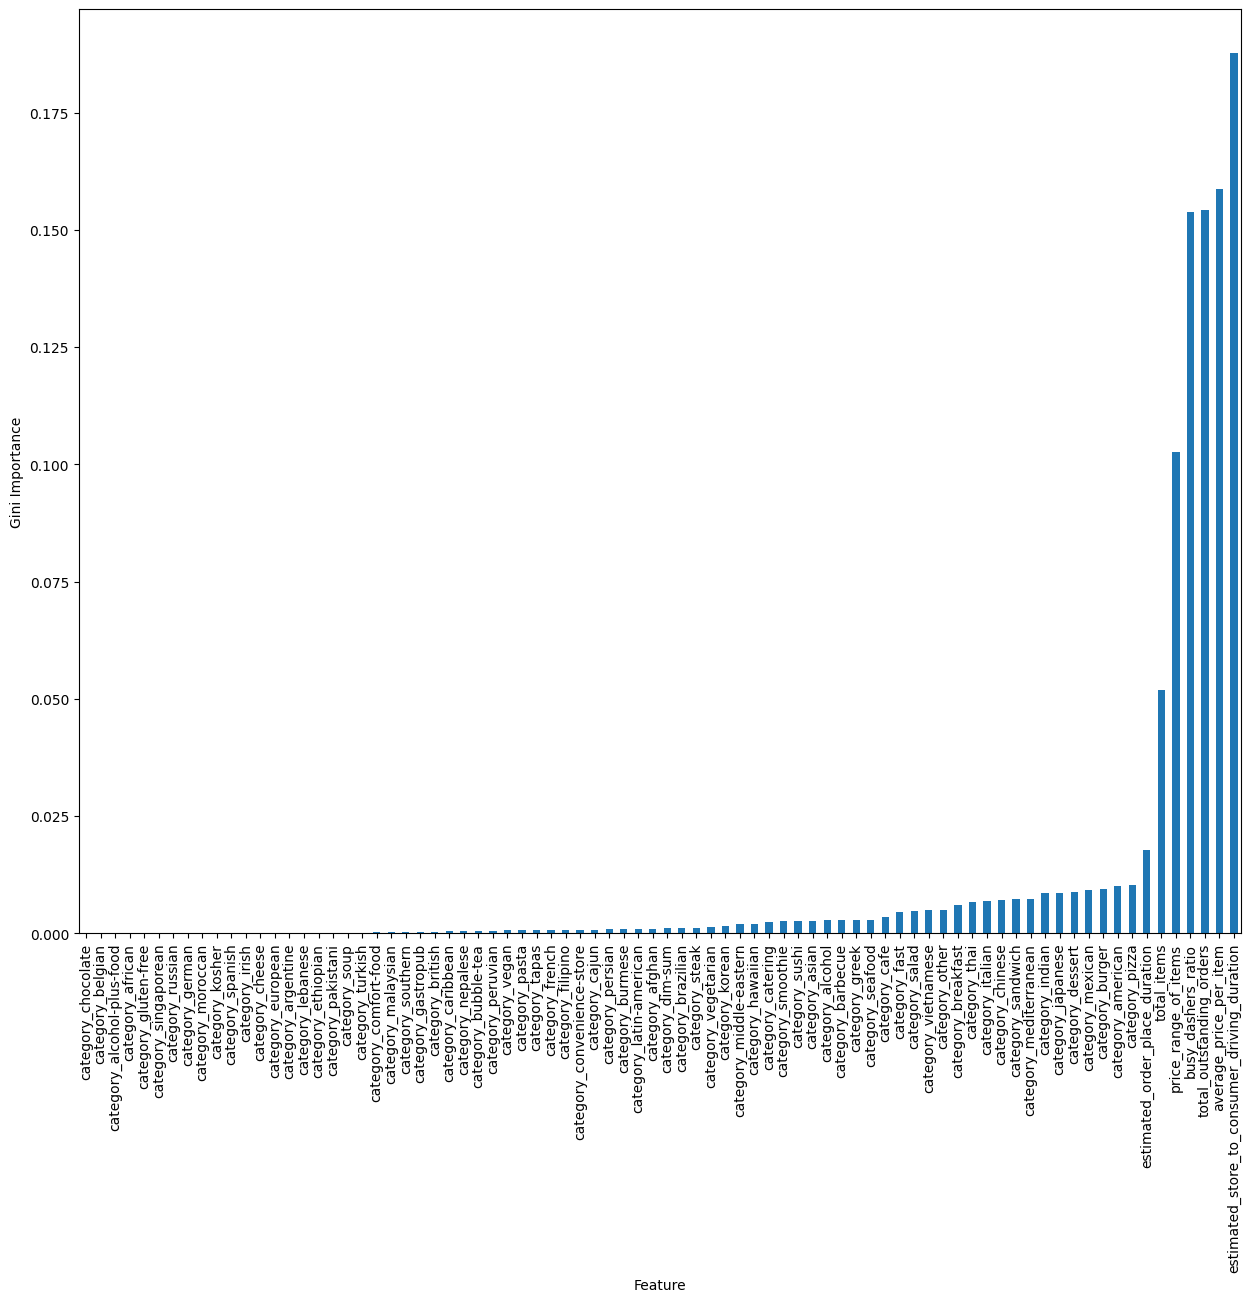

In [35]:
# Plot feature importances
importances = pd.Series(forest.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='bar', rot=90, figsize=(15, 12), xlabel='Feature', ylabel='Gini Importance')

<Axes: xlabel='Feature', ylabel='Gini Importance'>

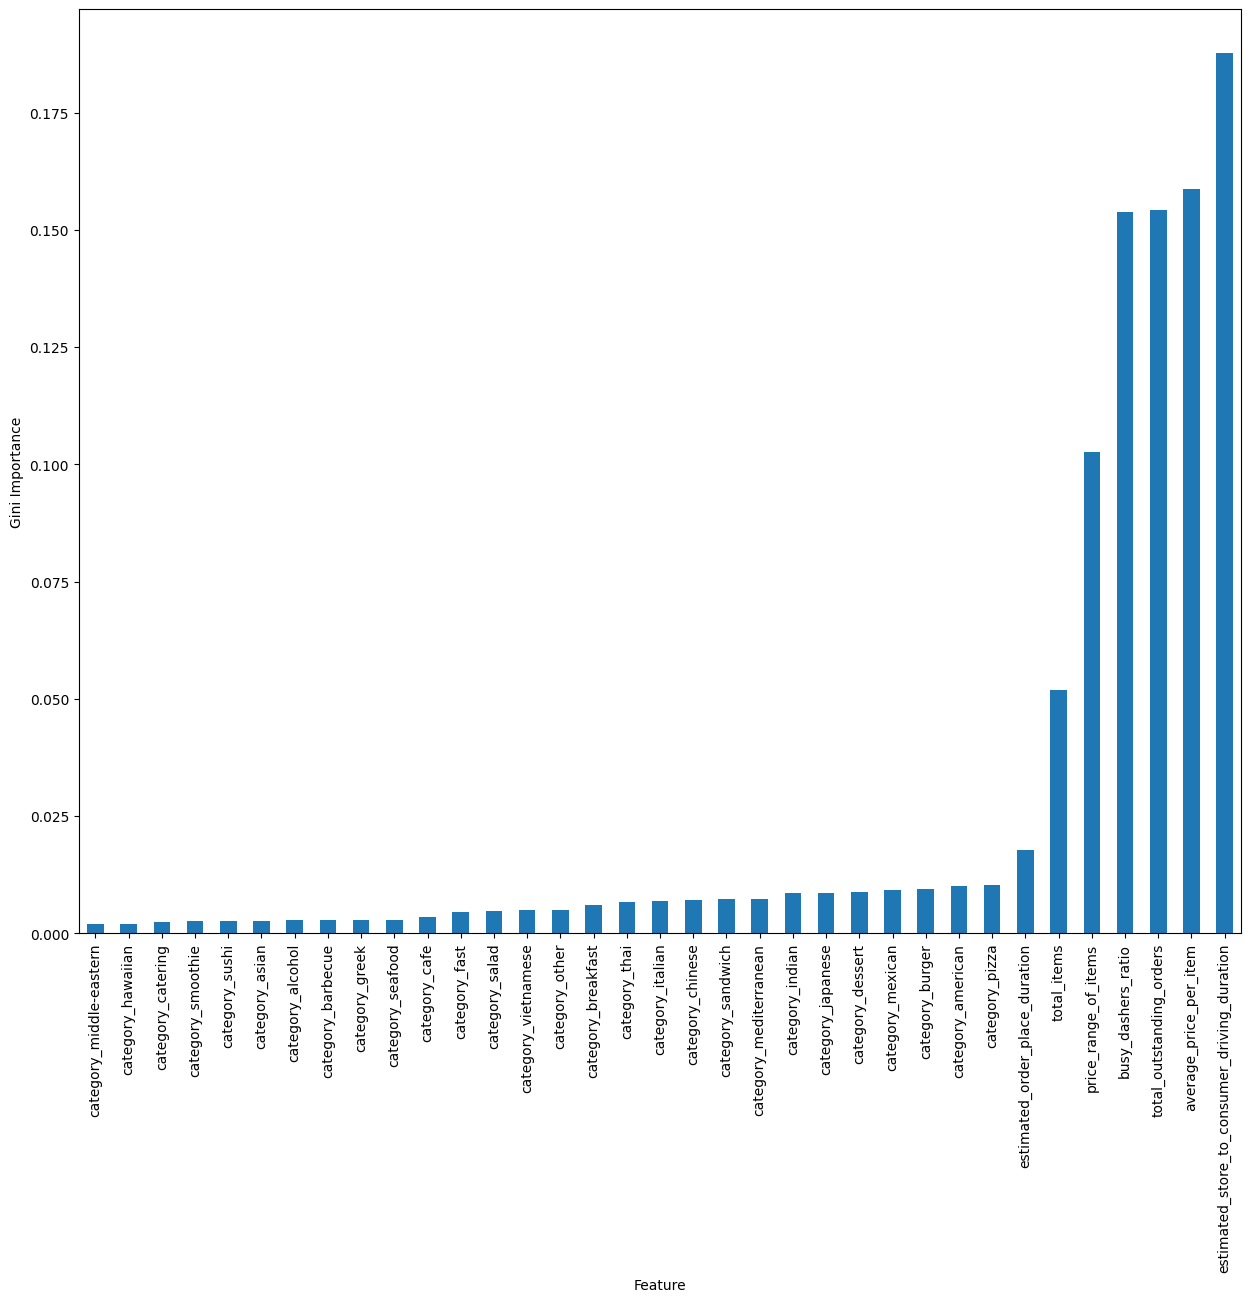

In [36]:
# Plot most important features
importances.sort_values()[-35:].plot(kind='bar', rot=90, figsize=(15, 12), xlabel='Feature', ylabel='Gini Importance')

In [37]:
# Get most important features as list
importances.sort_values()[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_alcohol',
 'category_barbecue',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_fast',
 'category_salad',
 'category_vietnamese',
 'category_other',
 'category_breakfast',
 'category_thai',
 'category_italian',
 'category_chinese',
 'category_sandwich',
 'category_mediterranean',
 'category_indian',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'average_price_per_item',
 'estimated_store_to_consumer_driving_duration']

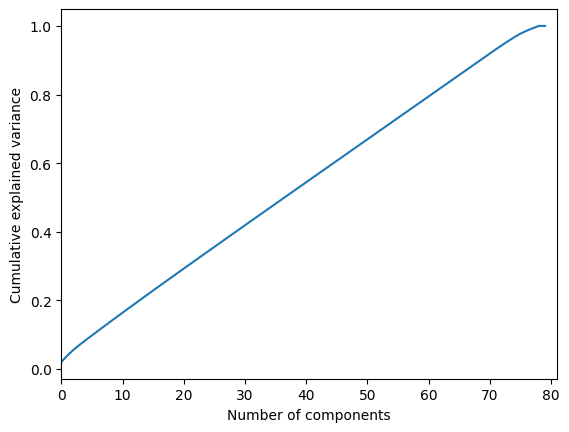

In [38]:
# Apply principal component analysis (PCA) to find feature contributions
X_Train = np.asarray(X_train.values)

# Find normalized array of X_Train
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)

# Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

PCA shows that using at least 60 representative feaures is required to explain 80% of the dataset. However, since there are already 80 features in the training data, and feature importance can identify crucial features, PCA transformation is not necessary. If PCA indicated significant variance explanation with around 10 features, a high reduction, its application would be considered.

## Apply Scaler <a id='apply-scaler'></a>

In [39]:
# Define scale function
def scale(scaler, X, y):
    """
    Apply scaler to feaures and target variables
    """
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler

In [40]:
# Scale data
X_scaled, y_scaled, scaler = scale(MinMaxScaler(), X, y)

In [41]:
# Split data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison <a id='inverse-transform'></a>

After scaling the training data, test data predictions will also be scaled. To assess error in seconds, inverse transformation will be applied. Root Mean Squared Error (RMSE) is chosen over Mean Squared Error (MSE) and Mean Absolute Error (MAE) due to its sensitivity to high error terms. This decision aligns with the idea that consumer patience with delivery delays might decrease exponentially with time. A detailed comparison of MAE, MSE, and RMSE can be found [here](https://towardsdatascience.com/comparing-robustness-of-mae-mse-and-rmse-6d69da870828).

In [42]:
# Define RMSE with inverse transform function
def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """
    Convert scaled error to actual error and calculate RMSE
    """
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    rmse_error = mean_squared_error(y_test, y_predict, squared=False)
    
    print(f'Error = {rmse_error} in {model_name}')
    
    return rmse_error, y_predict

## Machine Learning Models <a id='ml-models'></a>

In [43]:
# Create function for machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """
    Apply selected regression model to data and measure error
    """
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions and measure error on training data
    y_train_pred = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions and measure error on test data
    y_test_pred = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Print results
    if verbose:
        print(f'Train error = {train_error} in {model_name}')
        print(f'Test error = {test_error} in {model_name}')
        
    return model, y_test_pred, train_error, test_error

In [44]:
# Store prediction errors in dictionary
pred_dict = {
    'regression_model': [],
    'feature_set': [],
    'scaler_name': [],
    'RMSE': []
}

# Store regression models in dictionary
regression_models = {
    'Ridge': linear_model.Ridge(),
    'DecisionTree': tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP': MLPRegressor()
}

# Store feature sets in dictionary
feature_sets = {
    'full_dataset': X.columns.tolist(),
    'selected_features_40': importances.nlargest(n=40).index.tolist(),
    'selected_features_20': importances.nlargest(n=20).index.tolist(),
    'selected_features_10': importances.nlargest(n=10).index.tolist()
}

# Store scalers in dictionary
scalers = {
    'Standard scaler': StandardScaler(),
    'MinMax scaler': MinMaxScaler(),
    'Not scaled': None
}

In [45]:
# Find error for each combination of regression model, feature set, and scaler
for feature_set_name, feature_set in feature_sets.items():
    for scaler_name, scaler in scalers.items():
        print(f'-----Scaled with {scaler_name}-----included columns are {feature_set_name}\n')
        for model_name, model in regression_models.items():
            if scaler_name == 'Not scaled':
                X_train, X_test, y_train, y_test = train_test_split(X[feature_set], y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True)
            else:
                X_scaled, y_scaled, scaler = scale(scaler, X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], model, model_name, verbose=False)
                rmse_error, _ = rmse_with_inv_transform(scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)             

-----Scaled with Standard scaler-----included columns are full_dataset

Error = 2054.026611328125 in Ridge
Error = 2056.9446803075857 in DecisionTree
Error = 2049.821553635734 in RandomForest
Error = 2038.471923828125 in XGBoost
Error = 2038.614990234375 in MLP
-----Scaled with MinMax scaler-----included columns are full_dataset

Error = 2054.293701171875 in Ridge
Error = 2056.9446801886825 in DecisionTree
Error = 2048.6027821848234 in RandomForest
Error = 2037.46337890625 in XGBoost
Error = 2105.5390625 in MLP
-----Scaled with Not scaled-----included columns are full_dataset

Train error = 1072.0516357421875 in Ridge
Test error = 2054.019287109375 in Ridge


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.42527e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.777260295162 in DecisionTree
Test error = 2056.9446800369037 in DecisionTree
Train error = 398.1596346686891 in RandomForest
Test error = 2048.217739571209 in RandomForest
Train error = 964.0202026367188 in XGBoost
Test error = 2038.471923828125 in XGBoost


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1053.8460693359375 in MLP
Test error = 2047.2000732421875 in MLP
-----Scaled with Standard scaler-----included columns are selected_features_40

Error = 2054.30712890625 in Ridge
Error = 2056.5302004406567 in DecisionTree
Error = 2046.7606949750157 in RandomForest
Error = 2036.38330078125 in XGBoost
Error = 2038.0704345703125 in MLP
-----Scaled with MinMax scaler-----included columns are selected_features_40

Error = 2054.5830078125 in Ridge
Error = 2056.530200335329 in DecisionTree
Error = 2049.3434454465073 in RandomForest
Error = 2036.5859375 in XGBoost
Error = 2109.4423828125 in MLP
-----Scaled with Not scaled-----included columns are selected_features_40

Train error = 1072.8946533203125 in Ridge
Test error = 2054.30712890625 in Ridge


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.56064e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.7812948473952 in DecisionTree
Test error = 2056.530200195583 in DecisionTree
Train error = 397.7278317915795 in RandomForest
Test error = 2049.483644134499 in RandomForest
Train error = 963.3361206054688 in XGBoost
Test error = 2036.3831787109375 in XGBoost


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1054.719482421875 in MLP
Test error = 2047.8076171875 in MLP
-----Scaled with Standard scaler-----included columns are selected_features_20

Error = 2055.468017578125 in Ridge
Error = 2054.613812920652 in DecisionTree
Error = 2049.1430318024127 in RandomForest
Error = 2036.53515625 in XGBoost
Error = 2037.7696533203125 in MLP
-----Scaled with MinMax scaler-----included columns are selected_features_20

Error = 2055.759033203125 in Ridge
Error = 2054.6138129827436 in DecisionTree
Error = 2048.342210600622 in RandomForest
Error = 2036.4454345703125 in XGBoost
Error = 2082.407958984375 in MLP
-----Scaled with Not scaled-----included columns are selected_features_20

Train error = 1074.783935546875 in Ridge
Test error = 2055.46826171875 in Ridge


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.35799e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1308029967188 in DecisionTree
Test error = 2054.6138128839802 in DecisionTree
Train error = 402.22387080317475 in RandomForest
Test error = 2047.695785665385 in RandomForest
Train error = 972.0859375 in XGBoost
Test error = 2036.53515625 in XGBoost


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1057.5072021484375 in MLP
Test error = 2049.60400390625 in MLP
-----Scaled with Standard scaler-----included columns are selected_features_10

Error = 2056.58154296875 in Ridge
Error = 2054.5885413914198 in DecisionTree
Error = 2051.4667900554114 in RandomForest
Error = 2040.6380615234375 in XGBoost
Error = 2040.107421875 in MLP
-----Scaled with MinMax scaler-----included columns are selected_features_10

Error = 2056.894775390625 in Ridge
Error = 2054.588541451587 in DecisionTree
Error = 2049.6477478469196 in RandomForest
Error = 2039.88720703125 in XGBoost
Error = 2072.045166015625 in MLP
-----Scaled with Not scaled-----included columns are selected_features_10

Train error = 1076.865478515625 in Ridge
Test error = 2056.58154296875 in Ridge
Train error = 1069.2296162301652 in DecisionTree
Test error = 2054.588541355002 in DecisionTree
Train error = 402.55682188523303 in RandomForest
Test error = 2051.215541508077 in RandomForest
Train error = 980.9215087890625 in XGBoos

In [46]:
# Create DataFrame of predictions from dictionary
pred_df = pd.DataFrame(pred_dict)
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full_dataset,Standard scaler,2054.026611
1,DecisionTree,full_dataset,Standard scaler,2056.944680
2,RandomForest,full_dataset,Standard scaler,2049.821554
3,XGBoost,full_dataset,Standard scaler,2038.471924
4,MLP,full_dataset,Standard scaler,2038.614990
5,Ridge,full_dataset,MinMax scaler,2054.293701
6,DecisionTree,full_dataset,MinMax scaler,2056.944680
7,RandomForest,full_dataset,MinMax scaler,2048.602782
8,XGBoost,full_dataset,MinMax scaler,2037.463379
9,MLP,full_dataset,MinMax scaler,2105.539062


<Axes: >

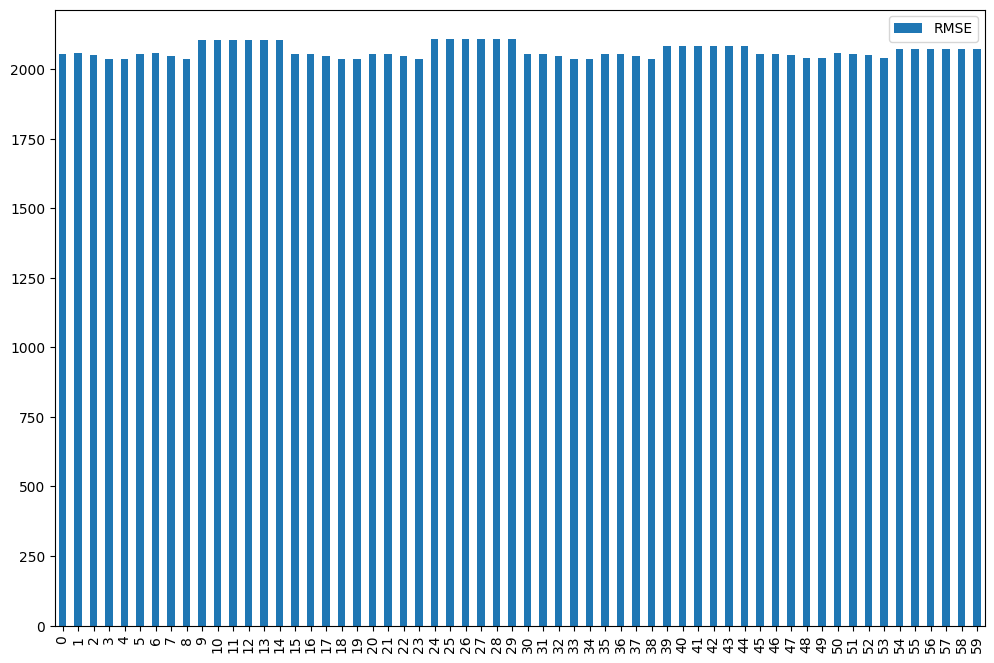

In [47]:
# Plot predictions
pred_df.plot(kind='bar', figsize=(12, 8))

Despite high errors across all models, scaling does not significantly impact performance, allowing flexibility in scaler selection. The reduction in training feature size initially improves performance, but a further decrease has marginal negative effects. Here, 40 features will be used. 

In evaluating model performances, the key concern is error rates. To enhance results, consider whether the dataset effectively represents total delivery duration estimation. One approach is predicting preparation time, and using the estimated store-to-consumer driving ratio and order placement to derive the total delivery duration. This strategy will be explored further.

In [48]:
# Create preparation time feature
train_df['prep_time'] = train_df['actual_total_delivery_duration'] - train_df['estimated_store_to_consumer_driving_duration'] - train_df['estimated_order_place_duration']

# Scaling may improve performance so use standard scaler (or MinMax)
scalers = {
    'Standard scaler': StandardScaler()
}

# Select 40 most important features
feature_sets = {
    'selected_features_40': importances.nlargest(n=40).index.tolist()
}

In [49]:
# Find error for each regression model given feature set and scaler
for feature_set_name, feature_set in feature_sets.items():
    for scaler_name, scaler in scalers.items():
        print(f'-----Scaled with {scaler_name}-----included columns are {feature_set_name}\n')
        for model_name, model in regression_models.items():
            # Drop columns
            X = train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration'])
            y = train_df['prep_time']
            
            # Get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # Scale
            X_scaled, y_scaled, scaler = scale(scaler, X, y)
            
            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], model, model_name, verbose=False)
            rmse_error, _ = rmse_with_inv_transform(scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)

-----Scaled with Standard scaler-----included columns are selected_features_40

Error = 2055.7138671875 in Ridge
Error = 2063.5462030532394 in DecisionTree
Error = 2050.2072783128783 in RandomForest
Error = 2036.8406982421875 in XGBoost
Error = 2039.7510986328125 in MLP


In [50]:
# Use best performing model
regression_models = {
    'XGBoost': XGBRegressor()
}

In [51]:
# Find error for XGBoost regression model given feature set and scaler
for feature_set_name, feature_set in feature_sets.items():
    for scaler_name, scaler in scalers.items():
        print(f'-----Scaled with {scaler_name}-----included columns are {feature_set_name}\n')
        for model_name, model in regression_models.items():
            # Drop columns
            X = train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration'])
            y = train_df['prep_time']
            
            # Get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # Scale
            X_scaled, y_scaled, scaler = scale(scaler, X, y)
            
            # Apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:, 0], X_test_scaled, y_test_scaled[:, 0], model, model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict['regression_model'].append(model_name)
            pred_dict['feature_set'].append(feature_set_name)
            pred_dict['scaler_name'].append(scaler_name)
            pred_dict['RMSE'].append(rmse_error)

-----Scaled with Standard scaler-----included columns are selected_features_40

Error = 2036.8406982421875 in XGBoost


In [52]:
# Choose best performing model and extract predictions for preparation duration
pred_values_dict = {
    'actual_total_delivery_duration': train_df['actual_total_delivery_duration'][test_indices].values.tolist(),
    'prep_duration_prediction': y_predict[:, 0].tolist(),
    'estimated_store_to_consumer_driving_duration': train_df['estimated_store_to_consumer_driving_duration'][test_indices].values.tolist(),
    'estimated_order_place_duration': train_df['estimated_order_place_duration'][test_indices].values.tolist()
}

In [53]:
# Convert dictionary to DataFrame
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1728.415771,380.0,251.0
1,1839.0,1534.289795,747.0,446.0
2,1927.0,2160.949219,543.0,251.0
3,2657.0,1249.455688,445.0,251.0
4,3596.0,1938.293579,691.0,446.0
...,...,...,...,...
35409,9557.0,2717.719727,768.0,446.0
35410,1864.0,2127.382568,324.0,446.0
35411,2674.0,1843.641724,791.0,251.0
35412,2234.0,1861.472046,687.0,251.0


In [54]:
# Sum predictions with non preparation activities including order placing and driving
values_df['sum_total_delivery_duration'] = values_df['prep_duration_prediction'] + values_df['estimated_store_to_consumer_driving_duration'] + values_df['estimated_order_place_duration']
values_df

,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1728.415771,380.0,251.0,2359.415771
1,1839.0,1534.289795,747.0,446.0,2727.289795
2,1927.0,2160.949219,543.0,251.0,2954.949219
3,2657.0,1249.455688,445.0,251.0,1945.455688
4,3596.0,1938.293579,691.0,446.0,3075.293579
...,...,...,...,...,...
35409,9557.0,2717.719727,768.0,446.0,3931.719727
35410,1864.0,2127.382568,324.0,446.0,2897.382568
35411,2674.0,1843.641724,791.0,251.0,2885.641724
35412,2234.0,1861.472046,687.0,251.0,2799.472046


In [55]:
# Check new error rate
mean_squared_error(values_df['actual_total_delivery_duration'], values_df['sum_total_delivery_duration'], squared=False)

2036.8407916778838

In [56]:
# Try using another regression model to get actual total delivery duration
X = values_df[['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']]
y = values_df['actual_total_delivery_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regression_models = {
    'LinearRegression' : linear_model.LinearRegression(),
    'Ridge' : linear_model.Ridge(),
    'DecisionTree' : tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest' : RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'MLP':  MLPRegressor(),
}

In [57]:
# Get RMSE of regression models
for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print(f'RMSE of {model_name}: {mean_squared_error(y_test, y_predict, squared=False)}')

RMSE of LinearRegression: 986.5046198322365
RMSE of Ridge: 986.504619835201
RMSE of DecisionTree: 1001.3815867260204
RMSE of RandomForest: 1458.3346237756455
RMSE of XGBoost: 1081.1397928926226
RMSE of MLP: 986.2618683166919


This approach has shown better performance, and can be chosen as the best solution.

## Deep Learning Model <a id='dl-model'></a>

In this case, there is a question if Artificial Neural Networks (ANNs) could outperform other models. The Multilayer Perceptron (MLP) model did not excel compared to tree-based regression in predicting preparation duration so the intuition is that an ANN is unlikely to perform better.

However, MLP showed high performance in predicting the overall delivery duration using preparation, driving, and order placement duration. Here, a deep learning model will be explored.

In [58]:
# Set seed for reproducibility
tf.random.set_seed(seed=42)

# Create neural network function
def create_model(feature_set_size):
    model = Sequential()
    model.add(Dense(units=16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='sgd', loss='mse', metrics=[RootMeanSquaredError()])
    return model

In [59]:
# Prepare data
scaler_name = 'Standard scaler'
feature_set_name = ['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']

# Set features
X = values_df[feature_set_name]

# Set target variable
y = values_df['actual_total_delivery_duration']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
X_scaled, y_scaled, scaler = scale(scalers[scaler_name], X, y)

# Split scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [60]:
# Train model and calculate error
print(f'-----Scaled with {scaler_name}-----included columns are {feature_set_name}')
print(f'feature_set_size: {X_train_scaled.shape[1]}')

# Initial model
model = create_model(feature_set_size=X_train_scaled.shape[1])

# Fit model to scaled training data
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)

# Make predictions on scaled test data
y_pred = model.predict(X_test_scaled)

# Calculate root mean squared error (RMSE)
rmse_error = rmse_with_inv_transform(scaler, y_test, y_pred, model_name='ANN')

# Record results
pred_dict['regression_model'].append('ANN')
pred_dict['feature_set'].append(feature_set_name)
pred_dict['scaler_name'].append(scaler_name)
pred_dict['RMSE'].append(rmse_error)

-----Scaled with Standard scaler-----included columns are ['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']
feature_set_size: 3
Epoch 1/100


2023-12-04 15:51:35.137716: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-12-04 15:51:35.137743: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-04 15:51:35.137760: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-04 15:51:35.137814: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 15:51:35.137852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 15/443 [>.............................] - ETA: 1s - loss: 0.3635 - root_mean_squared_error: 0.6029  

2023-12-04 15:51:35.441589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


443/443 [==============================] - 2s 3ms/step - loss: 1.1295 - root_mean_squared_error: 1.0628
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1202 - root_mean_squared_error: 1.0584
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1200 - root_mean_squared_error: 1.0583
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1198 - root_mean_squared_error: 1.0582
Epoch 5/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1202 - root_mean_squared_error: 1.0584
Epoch 6/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1198 - root_mean_squared_error: 1.0582
Epoch 7/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1200 - root_mean_squared_error: 1.0583
Epoch 8/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1193 - root_mean_squared_error: 1.0580
Epoch 9/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1199 - 

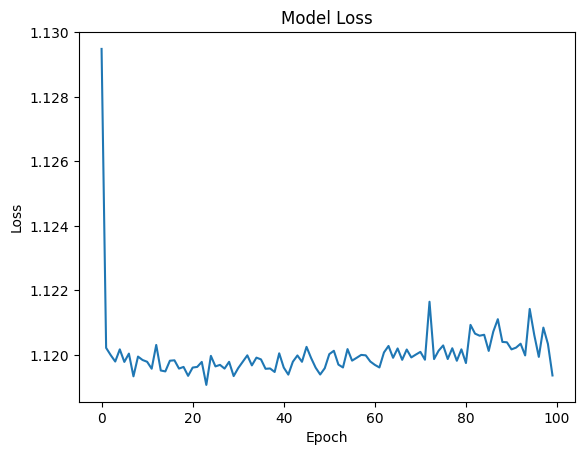

In [61]:
# Plot model loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This model shows similar performance with the MLP method from the scikit-learn library. It may be possible to improve performance with hyperparameter tuning, but this requires considerable time and effort.

A linear regression model shows acceptable performance with a simple and fast approach. Here, the best solution is using XGBoost with linear regression.

This notebook was inspired by the [Delivery Duration Prediction](https://platform.stratascratch.com/data-projects/delivery-duration-prediction) data project on [StrataScratch](https://www.stratascratch.com/).